<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/mmlu_eval_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an MMLU Eval

This notebook shows how to:
- Build and run an eval
- Load the results and into a Pandas Dataframe

We use the `evals.elsuite.basic.match:Match` Eval class here to check whether new completions match the correct answer. Under the hood, it will generate a completion with the choice of model for each prompt, check if the completion matches the true answer, then logs a result.

In [10]:
!pip install colab-env --upgrade -q
!pip install openai -q

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/openai/evals.git

In [2]:
%cd /content/evals/
!git lfs fetch --all
!git lfs pull

/content/evals
fetch: 704 object(s) found, done.
fetch: Fetching all references...


In [ ]:
# Install, and download MMLU if you haven't already
%cd /content/evals/
%pip install -e . -q

In [4]:
%cd /content/
!curl -O https://people.eecs.berkeley.edu/~hendrycks/data.tar
!tar -xf data.tar
data_path = "data"

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  158M  100  158M    0     0  48.0M      0  0:00:03  0:00:03 --:--:-- 48.0M


In [5]:
import pandas as pd
import os

# Assuming this notebook is in examples/
registry_path = os.path.join(os.getcwd(), "/content/evals/registry")
print(registry_path)

/content/evals/registry


In [6]:
# Build the prompts using Chat format. We support converting Chat conversations to text for non-Chat models

choices = ["A", "B", "C", "D"]
sys_msg = "The following are multiple choice questions (with answers) about {}."
def create_chat_prompt(sys_msg, question, answers, subject):
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": sys_msg.format(subject)},
        {"role": "user", "content": user_prompt}
    ]

def create_chat_example(question, answers, correct_answer):
    """
    Form few-shot prompts in the recommended format: https://github.com/openai/openai-python/blob/main/chatml.md#few-shot-prompting
    """
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": user_prompt, "name": "example_user"},
        {"role": "system", "content": correct_answer, "name": "example_assistant"},
    ]

In [7]:
data_path='/content/data'

In [ ]:
import yaml
subjects = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(data_path, "test")) if "_test.csv" in f])

registry_yaml = {}

for subject in subjects:
    print(subject)
    subject_path = os.path.join(registry_path, "data", "mmlu", subject)
    os.makedirs(subject_path, exist_ok=True)

    # Create few-shot prompts
    dev_df = pd.read_csv(os.path.join(data_path, "dev", subject + "_dev.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    dev_df["sample"] = dev_df.apply(lambda x: create_chat_example(x["Question"], x[["A", "B", "C", "D"]], x["Answer"]), axis=1)
    few_shot_path = os.path.join(subject_path, "few_shot.jsonl")
    dev_df[["sample"]].to_json(few_shot_path, lines=True, orient="records")

    # Create test prompts and ideal completions
    test_df = pd.read_csv(os.path.join(data_path, "test", subject + "_test.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    test_df["input"] = test_df.apply(lambda x: create_chat_prompt(sys_msg, x["Question"], x[["A", "B", "C", "D"]], subject), axis=1)
    test_df["ideal"] = test_df.Answer
    samples_path = os.path.join(subject_path, "samples.jsonl")
    test_df[["input", "ideal"]].to_json(samples_path, lines=True, orient="records")

    eval_id = f"match_mmlu_{subject}"

    registry_yaml[eval_id] = {
        "id": f"{eval_id}.test.v1",
        "metrics": ["accuracy"]
    }
    registry_yaml[f"{eval_id}.test.v1"] = {
        "class": "evals.elsuite.basic.match:Match",
        "args": {
            "samples_jsonl": samples_path,
            "few_shot_jsonl": few_shot_path,
            "num_few_shot": 4,
        }
    }
registry_path = '/content'
with open(os.path.join(registry_path, "evals", "mmlu.yaml"), "w") as f:
    yaml.dump(registry_yaml, f)

In [11]:
import colab_env
import os
import openai
from openai import OpenAI
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

Mounted at /content/gdrive


In [ ]:
from openai import OpenAI
client = OpenAI()

modellist=client.models.list()
modellist.data

In [11]:
#'mmlu-abstract-algebra', 'mmlu-abstract-algebra.val.ab-v1', 'mmlu-anatomy',
#'mmlu-anatomy.val.ab-v1', 'mmlu-astronomy', 'mmlu-astronomy.val.ab-v1',
#'mmlu-business-ethics', 'mmlu-business-ethics.val.ab-v1', 'mmlu-clinical-knowledge',
#'mmlu-clinical-knowledge.val.ab-v1', 'mmlu-college-biology', 'mmlu-college-biology.val.ab-v1',
#'mmlu-college-chemistry', 'mmlu-college-chemistry.val.ab-v1', 'mmlu-college-computer-science',
#'mmlu-college-computer-science.val.ab-v1', 'mmlu-college-mathematics',
#'mmlu-college-mathematics.val.ab-v1', 'mmlu-college-medicine',
#'mmlu-college-medicine.val.ab-v1', 'mmlu-college-physics', 'mmlu-college-physics.val.ab-v1',
#'mmlu-computer-security', 'mmlu-computer-security.val.ab-v1', 'mmlu-conceptual-physics',
#'mmlu-conceptual-physics.val.ab-v1', 'mmlu-econometrics', 'mmlu-econometrics.val.ab-v1',
#'mmlu-electrical-engineering', 'mmlu-electrical-engineering.val.ab-v1',
#'mmlu-elementary-mathematics', 'mmlu-elementary-mathematics.val.ab-v1',
#'mmlu-formal-logic', 'mmlu-formal-logic.val.ab-v1', 'mmlu-global-facts',
#'mmlu-global-facts.val.ab-v1', 'mmlu-high-school-biology', 'mmlu-high-school-biology.val.ab-v1',
#'mmlu-high-school-chemistry'

In [12]:
!pip install datasets -q

In [21]:
# This will generate a JSONL which will record samples and logs and store it in /tmp/evallogs
#!oaieval gpt-3.5-turbo match_mmlu_anatomy

%rm -rf /tmp/evallogs/*

#!oaieval gpt-3.5-turbo arc
#!oaieval gpt-3.5-turbo marxist_philosophy_exam

# abstract-causal-reasoning-text
# arc
# belarusian-antonyms

#!oaieval gpt-3.5-turbo belarusian-antonyms

#!oaieval gpt-3.5-turbo GPT-model-text-detection


#!oaieval gpt-3.5-turbo born-first --max_samples 10

!oaieval gpt-4 born-first #{'accuracy': 0.7213114754098361,
# [2024-05-29 09:16:14,785] [record.py:371] Final report: {'accuracy': 0.7049180327868853, 'boostrap_std': 0.041740393072744776, 'usage_completion_tokens': 122, 'usage_prompt_tokens': 3842, 'usage_total_tokens': 3964}. Logged to /tmp/evallogs/240529091602HPJ5YNDL_gpt-4_born-first.jsonl
# [2024-05-29 09:30:02,893] [record.py:371] Final report: {'accuracy': 0.7049180327868853, 'boostrap_std': 0.04203465060700257, 'usage_completion_tokens': 122, 'usage_prompt_tokens': 3842, 'usage_total_tokens': 3964}. Logged to /tmp/evallogs/240529092952FAA3EF37_gpt-4_born-first.jsonl
# [2024-05-29 10:25:41,172] [record.py:371] Final report: {'accuracy': 0.7213114754098361, 'boostrap_std': 0.04082302639454447, 'usage_completion_tokens': 122, 'usage_prompt_tokens': 3842, 'usage_total_tokens': 3964}. Logged to /tmp/evallogs/240529102529UV5E3FAZ_gpt-4_born-first.jsonl

#!oaieval gpt-3.5-turbo born-first #'accuracy': 0.5655737704918032,

#!oaieval gpt-3.5-turbo GPT-model-math
# marxist_philosophy_exam


[2024-05-29 10:25:27,841] [registry.py:271] Loading registry from /content/evals/evals/registry/evals
[2024-05-29 10:25:29,435] [registry.py:271] Loading registry from /root/.evals/evals
[2024-05-29 10:25:29,437] [oaieval.py:215] Run started: 240529102529UV5E3FAZ
[2024-05-29 10:25:29,633] [data.py:94] Fetching /content/evals/evals/registry/data/born_first/born_first.jsonl
[2024-05-29 10:25:29,634] [eval.py:36] Evaluating 122 samples
[2024-05-29 10:25:29,640] [eval.py:144] Running in threaded mode with 10 threads!
 89% 108/122 [00:09<00:00, 14.64it/s][2024-05-29 10:25:39,843] [record.py:360] Logged 221 rows of events to /tmp/evallogs/240529102529UV5E3FAZ_gpt-4_born-first.jsonl: insert_time=76.791ms
100% 122/122 [00:11<00:00, 10.63it/s]
[2024-05-29 10:25:41,171] [oaieval.py:275] Found 122/122 sampling events with usage data
[2024-05-29 10:25:41,172] [oaieval.py:283] Token usage from 122 sampling events:
completion_tokens: 122
prompt_tokens: 3,842
total_tokens: 3,964
[2024-05-29 10:25:41,

In [22]:
# import OS module
import os
# Get the list of all files and directories
path0 = "/tmp/evallogs/"
dir_list = os.listdir(path0)
events=path0
#print("Files and directories in '", events, "' :")
# prints all files
#print(dir_list)
events='%s%s'%(path0,dir_list[0])
print(events)

/tmp/evallogs/240529102529UV5E3FAZ_gpt-4_born-first.jsonl


<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

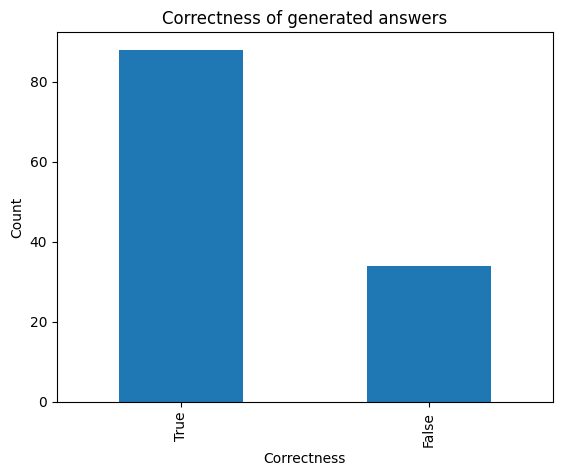

In [23]:
# How to process the log events generated by oaieval
#events = "/tmp/evallogs/{log_name}"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

matches_df = events_df[events_df.type == "match"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [24]:
# Inspect samples
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt}")
    print(f"Sampled: {r.sampled}")
    print("-" * 25)

Prompt: [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Was Grover Cleveland born before William McKinley? Answer Y or N.'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Was Franklin Roosevelt born before Herbert Hoover? Answer Y or N.'}]
Sampled: ['N']
-------------------------
Prompt: [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Was John Tyler born before James Buchanan? Answer Y or N.'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Was Martin Van Buren born before John Tyler? Answer Y or N.'}]
Sampled: ['Y']
-------------------------
Prompt: [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Was Andrew Jackson born before William Harrison? Answer Y or N.'}]
Sa

In [25]:
%cd /content/
!git clone https://github.com/xinzhel/llm_eval.git

/content
Cloning into 'llm_eval'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 42 (delta 4), reused 37 (delta 1), pack-reused 0
Receiving objects: 100% (42/42), 573.10 KiB | 11.24 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [26]:
from openai import OpenAI

client = OpenAI()

stream = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Say this is a test"}],
    stream=True,
)
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

This is a test.